1.3: Pipelines
================
### Stringing it All Together
_____________________

**Pipelines** has a few different meanings in Data Science.

This creates some ambiguity as the terms are often used interchangably.

There's [Spark Pipelines](https://spark.apache.org/docs/2.2.0/ml-pipeline.html), used to process data in PySpark. 

Then there's the overarching idea of the Data Science Pipeline: a concept in business that describes the general process for going from raw data to something that creates value for the business, as this [example](https://www.ibm.com/developerworks/library/ba-intro-data-science-1/index.html) from IBM illustrates.

Then, there is the scikit-learn Pipeline tool. This can be described as a simple way, using scikit-learn, to work through the beginning/middle steps of the Data Science Pipeline. **In scikit-learn, a Pipeline is a string of transforms with a final estimator.** All of these steps in the pipeline (transformers and estimators) can be user-defined or from scikit-learn.

**You can make user-defined pipeline steps by inheriting from the TransformerMixin and BaseEstimator parent classes**. If you inherit from these and write your transformer or estimator properly, they will work together in the pipeline seamlessly!



Scikit-learn pipelines to the rescue
-------------

Fortunately scikit-learn provides a set of helpful functions to deal with pipelines.
2 of them are the most important:

1. `sklearn.pipeline.make_pipeline`

    In our previous example we could define our transformer like this
    
```python
adder_normalizer = make_pipeline(
    AdderTransformer(add=10),
    MeanNormalizer()
)
```
Calling `fit` on the pipeline is the same as calling fit on each estimator in turn, transform the input and pass it on to the next step. The pipeline has all the methods that the last estimator in the pipeline has, i.e. if the last estimator is a classifier, the Pipeline can be used as a classifier. If the last estimator is a transformer, again, so is the pipeline.

2. `sklearn.pipeline.make_union`

    Creates a union of transformers
    
    ```
    
             transformer 1
           /               \
          /                 \
    input                     output
          \                 /    
           \               /
             transformer 2
             
    ```
             
    It is useful when the dataset consists of several types of data that one must 
    deal with separately.


Alternative way to define pipelines
--------------

```python
from sklearn.pipeline import Pipeline

adder_normalizer = Pipeline([
    ('adder', AdderTransformer(add=10)),
    ('normalizer', MeanNormalizer()),    
])

print(adder_normalizer)

>> Pipeline(steps=[('adder', <__main__.AdderTransformer object at 0x7f9387473750>), ('normalizer', <__main__.MeanNormalizer object at 0x7f9387137e50>)])
```



## Examples with real data: Predicting Absenteeism at Work
Here, we will take a real data set, and follow first the exploratory phase, then make it into a pipeline.

In [1]:
import pandas as pd 
import numpy as np

data = pd.read_csv('data/data.csv', index_col=0)
print(data.dtypes)
print('\n')
print('Summary Statistics for Target Variable \n', data['Absenteeism time in hours'].describe())
# we have a mix of categorical, numeric, and string data.
data.head()

ID                                   int64
Reason for absence                  object
Month of absence                     int64
Day of the week                     object
Distance from Residence to Work      int64
Service time                         int64
Age                                  int64
Work load Average/day              float64
Hit target                           int64
Disciplinary failure                 int64
Education                           object
Number of Children                   int64
Social drinker                       int64
Social smoker                        int64
Pet                                  int64
Weight                               int64
Height                               int64
Body mass index                      int64
Absenteeism time in hours            int64
dtype: object


Summary Statistics for Target Variable 
 count    740.000000
mean       6.924324
std       13.330998
min        0.000000
25%        2.000000
50%        3.000000
75%   

,ID,Reason for absence,Month of absence,Day of the week,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Number of Children,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
0,11,Patient follow-up,7,Tuesday,36,13,33,239.554,97,0,High school,2,1,0,1,90,172,30,4
1,36,No reason given,7,Tuesday,13,18,50,239.554,97,1,High school,1,1,0,0,98,178,31,0
2,3,Blood donation,7,Wednesday,51,18,38,239.554,97,0,High school,0,1,0,0,89,170,31,2
3,7,Diseases of the eye and adnexa,7,Thursday,5,14,39,239.554,97,0,High school,2,1,1,0,68,168,24,4
4,11,Blood donation,7,Thursday,36,13,33,239.554,97,0,High school,2,1,0,1,90,172,30,2


### Let's start by writing some initial tests to check our data:

In [2]:
# Checking that we don't have any null values
assert data.isnull().any().any() == False

# test passes. No missing values exist.

How can we get an initial idea of the shape and form of our data?

We can start by phrasing a few questions, and working to answer them.

#### 1. What is the average amount of time for which employees are sick?

In [3]:
data['Absenteeism time in hours'].mean()

6.924324324324324

#### 2. What is the average age of our employees?

In [4]:
data['Age'].mean()

36.45

#### 3. What are the most common reason that employees are absent?

In [5]:
data.groupby(['Reason for absence'])['Reason for absence'].count().sort_values(ascending=False)[0:5]

Reason for absence
Blood donation                                                  149
Dental Consultation                                             112
Physiotherapy                                                    69
Diseases of the muskuloskeletal system and connective tissue     55
No reason given                                                  43
Name: Reason for absence, dtype: int64

#### Write your own question and answer it:

### Now that we have a rough idea of the data, we can start preparing it for modeling.
At the very least, we need to:
1. Separate the target from the features
2. Split the data into test and train 
3. Encode the categorical features (also means separating them from the numeric features)
4. Scale the numeric features
5. Choose and apply a final estimator
6. Calculate the score of the estimator

**Which of these steps can we build into a pipeline?**

#### Non-pipeline steps:

In [6]:
target = data['Absenteeism time in hours']
features = data.drop('Absenteeism time in hours', axis=1)

In [7]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(features, target)

# Pipeline Steps: 
### Step 1: Building the Transformers

### Separating the numeric columns from the categorical ones:
Start with a test! What does the outcome look like?
We can start with the assert statement, and work backwards to developing a full test. 


```python
# checking that when we fit & transform with the transformer, we only have numeric columns.
for column in processed_df:
    assert is_numeric_dtype(df[column])
```


We can also start by defining what columns are categorical and what columns are numeric.

In [8]:
print(features.columns)

Index(['ID', 'Reason for absence', 'Month of absence', 'Day of the week',
       'Distance from Residence to Work', 'Service time', 'Age',
       'Work load Average/day ', 'Hit target', 'Disciplinary failure',
       'Education', 'Number of Children', 'Social drinker', 'Social smoker',
       'Pet', 'Weight', 'Height', 'Body mass index'],
      dtype='object')


Note: Some of the "numeric" columns are more categorical in nature (ex: month of absence, ID). We don't want to scale these as they are not continuous values. For this reason, we will split them out on their own.

We have 2 features with categories represented by strings.
There are 2 ways to deal with these: We can Label Encode them, essentially making them ordinal features (like ID already is). Or, we can one-hot encode them. This means making a column with binary values for each of the possible values of the feature.

The one that will work best for our purposes will depend on how many features there are, and the shape of our data.

Making 28 new columns for all of the reasons of absence can start to lead to the "curse of dimensionality', especially given that our data only has about 500 records.

In [9]:
len(set(features['Reason for absence']))

28

In [10]:
len(set(features['Education']))

4

In [11]:
numeric_columns = ['Distance from Residence to Work',
                   'Service time',
                   'Age',
                   'Work load Average/day ',
                   'Number of Children',
                   'Weight', 
                   'Height',
                   'Body mass index']

binary_columns = ['ID',
                  'Month of absence',
                  #'Day of the week',
                  'Disciplinary failure',
                  'Hit target',
                  'Social drinker', 
                  'Social smoker', 
                  'Pet']

label_encode_column = ['Reason for absence']
one_hot_encode_column = ['Education', 'Day of the week']

In [12]:
import ipytest.magics
import pytest
# set the file name (required)
__file__ = '1.3 Pipelines .ipynb'

In [13]:
from pandas.api.types import is_numeric_dtype

import warnings
warnings.filterwarnings("ignore")

Our test SHOULD fail! We haven't written the column selector yet!<br>
Our goal is to make the test pass.

In [14]:
%%run_pytest 

def test_ColumnSelector():
    # Here, showing a test case for both categoric and numeric datatypes.
    for column in numeric_df:
        assert is_numeric_dtype(numeric_df[column]) == True
    
    for column in categoric_df:
        assert is_numeric_dtype(categoric_df[column]) == False


============================= test session starts ==============================
platform darwin -- Python 3.6.3, pytest-3.2.1, py-1.4.34, pluggy-0.4.0
rootdir: /Users/rachelberryman/Documents/DSR_Model_Pipelines_Course, inifile:
collected 1 item

1.3 Pipelines .py F

=================================== FAILURES ===================================
_____________________________ test_ColumnSelector ______________________________

    def test_ColumnSelector():
        # Here, showing a test case for both categoric and numeric datatypes.
>       for column in numeric_df:
E       NameError: name 'numeric_df' is not defined

<ipython-input-14-005d543dfbd4>:4: NameError
=========================== 1 failed in 0.17 seconds ===========================


In [15]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import Imputer

In [16]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, x, y = None):
        return self
    
    def transform(self, x):
        cols = x.loc[:,self.columns]
        return cols

Now, let's see if we can make our test pass:

In [17]:
numeric_selector = ColumnSelector(numeric_columns)
numeric_df = numeric_selector.fit_transform(x_train)

label_encode_selector = ColumnSelector(label_encode_column)
label_encode_df = label_encode_selector.fit_transform(x_train)

one_hot_encode_selector = ColumnSelector(one_hot_encode_column)
one_hot_encode_df = one_hot_encode_selector.fit_transform(x_train)

binary_selector = ColumnSelector(binary_columns)
binary_df = binary_selector.fit_transform(x_train)

In [18]:
%%run_pytest 

def test_ColumnSelector():
    # Here, showing a test case for both categoric and numeric datatypes.
    for column in numeric_df:
        assert is_numeric_dtype(numeric_df[column]) == True
    
    assert is_numeric_dtype(label_encode_df) == False
    assert is_numeric_dtype(one_hot_encode_df) == False

============================= test session starts ==============================
platform darwin -- Python 3.6.3, pytest-3.2.1, py-1.4.34, pluggy-0.4.0
rootdir: /Users/rachelberryman/Documents/DSR_Model_Pipelines_Course, inifile:
collected 1 item

1.3 Pipelines .py .

=========================== 1 passed in 0.02 seconds ===========================


### Now, we can write more tests for the additional transformers we want to add into our pipeline.
<del>`class CategoricFeatureEncoder(BaseEstimator, TransformerMixin):`</del>

we don't need to write our own class for this. Scikit-learn already has many built in. **When possible, don't reinvent the wheel. Use the transformers that are already there for you!**

We will use 2 different encoders in our pipeline. The feature "Reason for absence" has 28 distinct categories. This is too many to one-hot encode and would add too many features when our dataset only has 740 records.

We can still write some tests to see that they're working correctly. We'll start by using our ColumnSelector transformer (from our tests above) to separate out the 2 columns.

In [19]:
from category_encoders.ordinal import OrdinalEncoder

Note: Why are we not using sk-learn's [Label Encoder](), which works the same way as the [Ordinal Encoder](http://contrib.scikit-learn.org/categorical-encoding/ordinal.html) from the Category Encoders package? Because the sci-kit learn one (somehow) [doesn't work](https://github.com/scikit-learn/scikit-learn/issues/3112) with pipelines.


In [20]:
%%run_pytest 

def test_LabelEncoder():
    encoder = OrdinalEncoder()
    encoded_df = encoder.fit_transform(label_encode_df.values)
    
    # check for data leakage
    assert encoded_df.shape[0] == label_encode_df.shape[0]
    
    # check that all values have been converted into integers
    assert encoded_df.values.dtype == 'int64'

============================= test session starts ==============================
platform darwin -- Python 3.6.3, pytest-3.2.1, py-1.4.34, pluggy-0.4.0
rootdir: /Users/rachelberryman/Documents/DSR_Model_Pipelines_Course, inifile:
collected 2 items

1.3 Pipelines .py ..

=========================== 2 passed in 0.04 seconds ===========================


### Exercise: Write a test for the One-Hot Encoder:

**Double click to see the solution**

<div class='spoiler'>

<div>

**Question**: Why are we not using the One-Hot Encoder from Scikit-Learn?

In [21]:
!pip install category_encoders

boto3 1.5.33 has requirement botocore<1.9.0,>=1.8.47, but you'll have botocore 1.10.19 which is incompatible.
bacnet-controller 0.0.1 has requirement boto3==1.5.12, but you'll have boto3 1.5.33 which is incompatible.
bacnet-controller 0.0.1 has requirement pytz==2018.3, but you'll have pytz 2017.2 which is incompatible.


In [22]:
from category_encoders.one_hot import OneHotEncoder
one_hot = OneHotEncoder()
one_hot_encoded_df = one_hot.fit_transform(one_hot_encode_df.values)

In [23]:
%%run_pytest[clean]

def test_OneHotEncoder():
    one_hot_encoder = OneHotEncoder()
    one_hot_encoded_df = one_hot.fit_transform(one_hot_encode_df.values)
    
    # check for data leakage
    assert one_hot_encoded_df.shape[0] == one_hot_encode_df.shape[0]
    
    # check that all values have been converted into integers
    assert one_hot_encoded_df.dtypes.all() == 'int64'
    
    # check that only 0s and 1s exist in the new matrix
    assert ((one_hot_encoded_df.values ==0) | (one_hot_encoded_df.values ==1)).all()
    
    # check that a dummy column has been made for each potential category 
    assert one_hot_encoded_df.shape[1] == len(set(one_hot_encoded_df))

============================= test session starts ==============================
platform darwin -- Python 3.6.3, pytest-3.2.1, py-1.4.34, pluggy-0.4.0
rootdir: /Users/rachelberryman/Documents/DSR_Model_Pipelines_Course, inifile:
collected 1 item

1.3 Pipelines .py .

=========================== 1 passed in 0.05 seconds ===========================


### Back to Numeric Data: Using Standard Scaler

In [24]:
numeric_df.head()

,Distance from Residence to Work,Service time,Age,Work load Average/day,Number of Children,Weight,Height,Body mass index
620,14,16,58,222.196,2,65,172,22
310,52,3,28,265.017,1,80,172,27
180,5,14,39,343.253,2,68,168,24
646,51,18,38,222.196,0,89,170,31
710,49,11,36,275.089,2,65,174,21


In [25]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_numeric = scaler.fit_transform(numeric_df)

## Now, to Pipelines!
We've tested our transformers and are sure they are working. What we need to do now is string them together in a pipeline, and re-combine the various features.

Without a pipeline, we would have had to do this by merging all or our new features. 
This is difficult, since after scaling, the numeric features are a matrix. The binary and categoric features are still dataframes.
A pipeline, combined with another scikit-learn tool `make_union`, does all of this work for us.

In [26]:
all_columns = list(features.columns)

In [27]:
from sklearn.pipeline import make_pipeline, make_union

# process the numeric and categorical columns.
# then, join them all together.

processing_pipeline = make_pipeline(
    # If using make_union, then we HAVE to first select all the columns we will pull from.
    ColumnSelector(all_columns),
    make_union(
        # First, we select and 'hold out' the binary variables, as we wont do any further work to them.
        make_pipeline(ColumnSelector(binary_columns),
        ),
        # Pipeline for numeric features
        make_pipeline(
            ColumnSelector(numeric_columns),
            StandardScaler()
        ),
        # Pipeline for label encoded features
        make_pipeline(
            ColumnSelector(label_encode_column),
            OrdinalEncoder()
        ),
        
        # Pipeline for one-hot-encoded features
        make_pipeline(
            ColumnSelector(one_hot_encode_column),
            OneHotEncoder()
        )
    )
)

In [28]:
processed = processing_pipeline.fit_transform(features)

#### Now, let's write a test to make sure that we didn't lose any data when we strung all of our transformers and estimators together.

In [29]:
%%run_pytest[clean]

def test_processingpipeline():
    # remember, this first pipeline only acts on the features, not the target.
    processed = processing_pipeline.fit_transform(features)
    
    # check for data leakage
    assert features.shape[0] == processed.shape[0]


============================= test session starts ==============================
platform darwin -- Python 3.6.3, pytest-3.2.1, py-1.4.34, pluggy-0.4.0
rootdir: /Users/rachelberryman/Documents/DSR_Model_Pipelines_Course, inifile:
collected 1 item

1.3 Pipelines .py .

=========================== 1 passed in 0.06 seconds ===========================


### Finally, choosing the final estimator.
We can use our estiamtor tests we wrote in the beginning of class, when we learned about tests.

In [65]:
# setting random seed for reproducability. 
np.random.seed(10)

In [66]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_predict

In [67]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(verbose=True, n_jobs=-1)
finalpipeline = (make_pipeline(processing_pipeline, RandomForestRegressor()))

In [68]:
finalpipeline.fit(x_train, y_train)
predictions = finalpipeline.predict(x_test)

In [69]:
from math import sqrt
print('RMSE', sqrt(mean_squared_error(y_test, predictions)))
print('MAE', mean_absolute_error(y_test, predictions))
print('R^2', -r2_score(y_test, predictions))

RMSE 9.906147325516354
MAE 4.974684684684685
R^2 0.32842001665280507


In [70]:
y_test = y_test.reset_index()
y_test.drop('index', axis=1, inplace=True)
final_predictions = pd.DataFrame(pd.concat([y_test, pd.Series(predictions)], axis=1))

In [71]:
final_predictions.rename(columns={'Absenteeism time in hours': 'True values', 0: 'Predicted values'}, inplace=True)

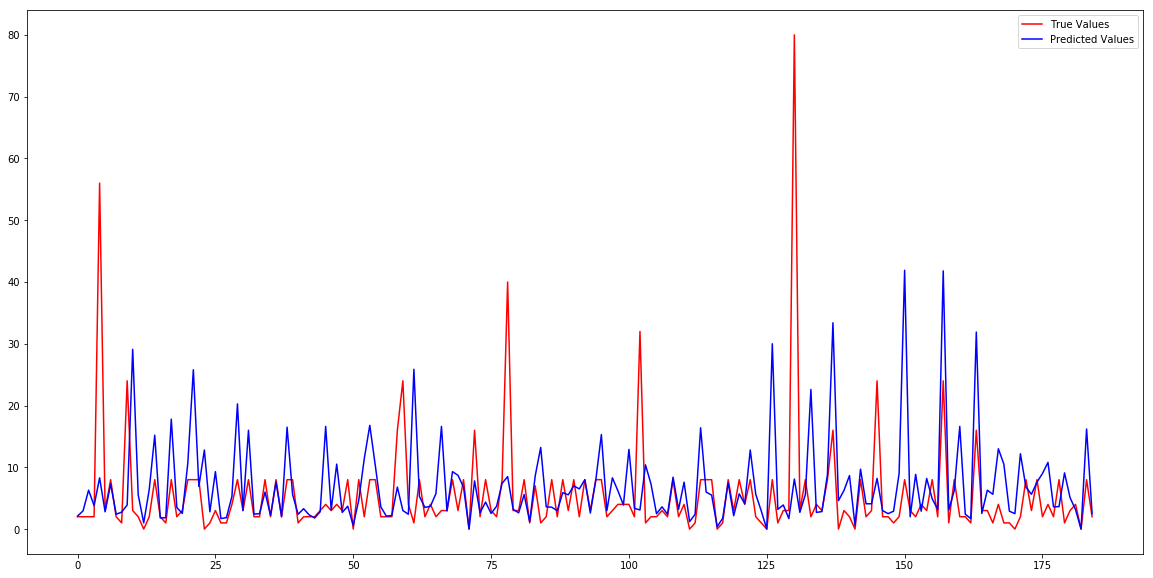

In [72]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))

plt.plot(final_predictions.index, final_predictions['True values'], c='red', label='True Values')
# plot a second data series 'Short students' in blue using the last three elements of x and y 
plt.plot(final_predictions.index, final_predictions['Predicted values'], c='blue', label='Predicted Values')
plt.legend(loc='best')
plt.show()

## How can we improve our predictions?
#### Going back to exploration.
We use pipelines to GridSearch over hyperparameters and choose a better model. 

Grid search
--------------------------

Scikit-learn has `GridSearchCV` and `RandomizedSearchCV`. Both have the same functionality and can be used to find optimal hyperparameters for sk-learn models. What is great about both these classes that they are both transformers - *they return an estimator so you can chain them and put in your pipeline*!

**GridSearchCV** - you specify the exact values of the parameters you want to test. <br>
**RandomizedSearchCV** - you specify ranges of parameters

In contrast to GridSearchCV, not all parameter values are tried out, but rather a fixed number of parameter settings is sampled from the specified distributions. The number of parameter settings that are tried is given by n_iter.

Exercise
----------------------

1. Use `GridSearchCV` or `RandomizedSearchCV` to find the best parameters for the models. Check at least 2 parameters.

2. Inspect the attribute `cv_results_` after fitting. It gives a nice representation of the learning.

In [109]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'randomforestregressor__n_estimators': n_estimators,
               'randomforestregressor__max_features': max_features,
               'randomforestregressor__max_depth': max_depth,
               #'randomforestregressor__min_samples_split': min_samples_split,
               #'randomforestregressor__min_samples_leaf': min_samples_leaf,
               #'randomforestregressor__bootstrap': bootstrap
              }

print(random_grid)

{'randomforestregressor__n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'randomforestregressor__max_features': ['auto', 'sqrt'], 'randomforestregressor__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None]}


In [110]:
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV

In [111]:
small_grid = {'randomforestregressor__n_estimators': n_estimators,
               'randomforestregressor__max_features': max_features,}

In [104]:
clf = GridSearchCV(finalpipeline,
                   param_grid=small_grid,
                   cv=2,
                   refit=True
                   )

clf.fit(x_train, y_train)
clf_preds = clf.predict(x_test)
# putting clf_predictions into a series so that we can plot them.
clf_preds = pd.Series(clf_preds)
clf_preds.rename("Grid Search Predicted values", inplace=True)

In [106]:
print('RMSE', sqrt(mean_squared_error(y_test, clf_preds)))
print('MAE', mean_absolute_error(y_test, clf_preds))
print('R^2', r2_score(y_test, clf_preds))

RMSE 8.435137286968013
MAE 4.128142020592021
R^2 0.03681401086125469


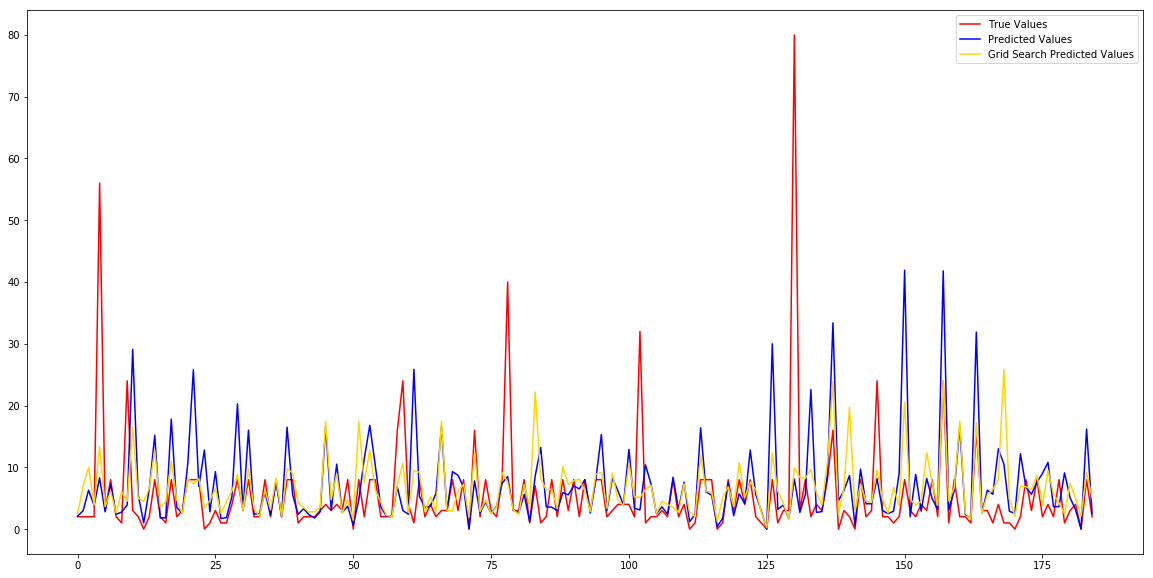

In [127]:
plt.figure(figsize=(20,10))

plt.plot(final_predictions.index, final_predictions['True values'], c='red', label='True Values')
# plot a second data series 'Short students' in blue using the last three elements of x and y 
plt.plot(final_predictions.index, final_predictions['Predicted values'], c='blue', label='Predicted Values')
clf_preds.plot(c='gold', label='Grid Search Predicted Values')
plt.legend(loc='best')
plt.show()

In [107]:
best_params = sorted(clf.grid_scores_, key=lambda x: -x[1])
for params, score, _ in best_params:
    print(score, params) 

0.08458790214608157 {'randomforestregressor__max_features': 'sqrt', 'randomforestregressor__n_estimators': 200}
0.07708385040943892 {'randomforestregressor__max_features': 'sqrt', 'randomforestregressor__n_estimators': 400}
0.07135355030195968 {'randomforestregressor__max_features': 'sqrt', 'randomforestregressor__n_estimators': 1600}
0.06863827776975874 {'randomforestregressor__max_features': 'sqrt', 'randomforestregressor__n_estimators': 600}
0.06861788498405844 {'randomforestregressor__max_features': 'sqrt', 'randomforestregressor__n_estimators': 800}
0.06853015886575459 {'randomforestregressor__max_features': 'sqrt', 'randomforestregressor__n_estimators': 2000}
0.06672075413626657 {'randomforestregressor__max_features': 'sqrt', 'randomforestregressor__n_estimators': 1200}
0.061122122609236086 {'randomforestregressor__max_features': 'sqrt', 'randomforestregressor__n_estimators': 1000}
0.05995956895803573 {'randomforestregressor__max_features': 'sqrt', 'randomforestregressor__n_estim

We are using the MAE score as the criteria for which model is "best". <br>
For information about MAE vs. RMSE vs. R^2, you can read [here](https://medium.com/usf-msds/choosing-the-right-metric-for-machine-learning-models-part-1-a99d7d7414e4).<br>
[This list](http://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter) shows the string names of each scoring metric to use when setting it in GridSearchCV and RandomSearchCV.

In [ ]:
print("Grid search")
print('\n')

params = random_grid

grid_clf = GridSearchCV(finalpipeline, params, n_jobs=-1, verbose=True, scoring='neg_mean_absolute_error')
grid_clf.fit(x_train, y_train)

best_params = sorted(grid_clf.grid_scores_, key=lambda x: -x[1])

print('Grid Search best score: ', grid_clf.best_score_)

# for params, score, _ in best_params:
#     print(score, params) 
    
print("Randomized search")
print()
    
params = random_grid

grid_clf = RandomizedSearchCV(final_pipeline, params, n_jobs=1, verbose=True, n_iter=8, scoring='neg_mean_absolute_error')
grid_clf.fit(np.array(x_train), y_train)

best_params = sorted(grid_clf.grid_scores_, key=lambda x: -x[1])

print('Random Search best score: ', grid_clf.best_score_)

# for params, score, _ in best_params:
#     print(score, params)

Grid search


Fitting 3 folds for each of 240 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  5.3min
